## KNN FROM SCRATCH USING TFIDF WORD EMBEDDING & MI BASED FEAT' SELECTION

### IMPORTING REQUIRED MODULES

In [12]:
import re
from nltk import word_tokenize
import glob  
from nltk.corpus import stopwords
import time
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
import os
import sys 
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import math
import json
import numpy as np
import pandas as  pd
from prettytable import PrettyTable
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from statistics import mode
from sklearn.metrics import confusion_matrix
import itertools
import copy
from IPython.display import display

### DATA PREPROCESSING FUNCTION

In [13]:
def preprocess(data):
    stopword=""
    cleantext = " "
    stopword = set(stopwords.words('english'))
    for i in word_tokenize(data):
        i=i.lower()
        if i not in stopword and len(i)>2 and not(any(l.isdigit() for l in i)):
            pattern1 = '[!.?$\[\]/\}#=<>"\*:,|_~;()^\']'
            pattern2 = '[\n\n]+'
            pattern3 = '[\ \ ]+'
            wout_sc = re.sub(pattern1,'',i) #removing special characters
            wout_el = re.sub(pattern2,'\n',wout_sc) # removing empty lines (which are greater than 2)
            wout_mspaces = re.sub(pattern3,' ',wout_el) # removing multiple spaces
            cleaned_text = wout_mspaces.strip()
            cleaned_text=lemmatizer.lemmatize(cleaned_text)
            cleantext = cleantext+cleaned_text+" "
    return cleantext.strip()

### READING THE NAMES OF THE FILES

In [14]:
def read_names(path):
    i=0
    df = pd.DataFrame(columns=['Doc_Name'])
    folders = glob.glob(path)
    for f in tqdm(folders,leave=True,position=0):
        head,tail = os.path.split(f)
        if(tail=="comp.graphics"or tail=="sci.med"or tail=="talk.politics.misc"or tail=="rec.sport.hockey"or tail=="sci.space"):
            for file in glob.glob(f+"\*"):
                head1,tail1 = os.path.split(file)
                df.loc[i] = tail+"_"+tail1
                i=i+1
    return df

### PERFORMING TRAIN-TEST SPLIT

In [15]:
def split(ratio,data_frame):
    data_frame_temp = data_frame.copy()
    train_files,test_files = train_test_split(data_frame_temp,train_size=ratio,random_state=0)
    return train_files,test_files

### READING THE DATA & BUILDING TFs and DFs FOR TRAINING SET
### CORPUS CONSIDERED :: "20 news groups" 
### FOLDERS CONSIDERED: 
### 1. comp.graphics 
### 2. sci.med 
### 3.talk.politics.misc 
### 4.rec.sport.hockey 
### 5.sci.space

In [25]:
def readfiles(path,ratio,test_files):
    folders = glob.glob(path)
    preproc_data_dict={} ## key : file-name, value: pre-processed data
    train_files_class_wise={}
    test_preproc_dict={}
    train_files_doc_wise={}
    tfs_doc_wise={}
    df_dict_doc_wise={}
    for f in tqdm(folders,leave=True,position=0):
        head,tail = os.path.split(f)
        if(tail=="comp.graphics"or tail=="sci.med"or tail=="talk.politics.misc"or tail=="rec.sport.hockey"or tail=="sci.space"):
            for file in glob.glob(f+"\*"):
                flag=0
                head1,tail1 = os.path.split(file)
                with open(file) as newlinetest:   ## identifying the first new line in the data.. to remove meta-data
                    indi = newlinetest.readlines()
                for newline in range(len(indi)):
                    if(indi[newline]!="\n"):
                        continue
                    break
                filedata=[]
                try:
                    with open(file,"r") as data:  ## READING THE DATA ignoring the meta-data
                        filedata.append(data.readlines()[newline+1:])
                        for l in range(len(filedata)):
                            inter_data = ' '.join(filedata[l])
                    preproc_data = preprocess(inter_data)
                    if(tail+"_"+tail1 not in list(test_files['Doc_Name'])): ## reading only the training data
                        train_files_doc_wise[tail+"_"+tail1] = preproc_data
                        if tail not in train_files_class_wise:
                            train_files_class_wise[tail]=1
                        else:
                            train_files_class_wise[tail]+=1
                        if tail not in preproc_data_dict: ## merging the data of all documents belonging to a single class..
                            preproc_data_dict[tail] = preproc_data
                        else:
                            preproc_data_dict[tail] = preproc_data_dict[tail]+" "+preproc_data
                    else:
                        test_preproc_dict[tail+"_"+tail1] = preproc_data
                    
                except e:
                    print("EXCEPTION OCCURED..")
    print("TOTAL TRAINING FILES READ::",len(train_files_doc_wise.keys()))
    print("\n====> GENERATING TFs DOC WISE...\n")
    for d in tqdm(train_files_doc_wise,leave=True,position=0): ## computing term-frequencies doc-wise....
        tf_dict={}
        for w in train_files_doc_wise[d].split():
            if w not in tf_dict:
                tf_dict[w]=1
            else:
                tf_dict[w]+=1
        tfs_doc_wise[d] = tf_dict
    
    print("\n====> GENERATING IDFs DOC WISE...\n")
    #data=" "  
    #for d in train_files_doc_wise: ## computing inverse document frequencies doc-wise...
    #    data = data+" "+train_files_doc_wise[d] ## computing inverse document frequencies...
    #unique_words = list(set(data.split()))
    #for w in tqdm(unique_words,leave=True,position=0):
    #    df_dict_doc_wise[w]=0
    #    for key in train_files_doc_wise:
    #        if w in train_files_doc_wise[key]:
    #            df_dict_doc_wise[w]+=1
    #    df_dict_doc_wise[w] = math.log10(len(train_files_doc_wise.keys())/df_dict_doc_wise[w])
    tfidfs_doc_wise = copy.deepcopy(tfs_doc_wise)
    
    if(ratio==0.50):
        pickle_in = open("df_docwise_knn_tfidf_5050","rb")
        df_dict_doc_wise = pickle.load(pickle_in)
        print("DOC WISE IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!")
    if(ratio==0.70):
        pickle_in = open("df_docwise_knn_tfidf_7030","rb")
        df_dict_doc_wise = pickle.load(pickle_in)
        print("DOC WISE IDF VALUES CORRESPONDING TO 70:30 SPLIT LOADED...!!!")
    if(ratio==0.80):
        pickle_in = open("df_docwise_knn_tfidf_8020","rb")
        df_dict_doc_wise = pickle.load(pickle_in)
        print("DOC WISE IDF VALUES CORRESPONDING TO 80:20 SPLIT LOADED...!!!")
    
    print("\n====> GENERATING TF-IDFS DOC WISE...\n")
    for i in tqdm(tfidfs_doc_wise,leave=True,position=0):
        for j in tfidfs_doc_wise[i]:
            tfidfs_doc_wise[i][j] = (1+math.log10(tfidfs_doc_wise[i][j]))*df_dict_doc_wise[j]
    print("LENGTH OF VOCABULARY::",len(df_dict_doc_wise))        
    ###LOADING THE DATAFRAMES OF MUTUAL INFORMATION TABLE FOR A PARTICULAR SPLIT...
    if(ratio==0.50):
        pickle_in = open("mi_table_5050","rb")
        df = pickle.load(pickle_in)
        print("MI TABLE CORRESPONDING TO 50:50 SPLIT LOADED...!!!")
    if(ratio==0.70):
        pickle_in = open("mi_table_7030","rb")
        df = pickle.load(pickle_in)
        print("MI TABLE CORRESPONDING TO 70:30 SPLIT LOADED...!!!")
    if(ratio==0.80):
        pickle_in = open("mi_table_8020","rb")
        df = pickle.load(pickle_in)
        print("MI TABLE CORRESPONDING TO 80:20 SPLIT LOADED...!!!")
    return df,test_preproc_dict,tfidfs_doc_wise,train_files_class_wise,df_dict_doc_wise

### GENERATING TRAIN AND TEST VECTORS

In [26]:
def gen_vectors(mis_cls_and_term_wise,tfidfs_doc_wise,test_preproc_dict,df_dict_doc_wise):
    top_features=set()
    test_temp={}
    test_vectors_tfidfs={}
    train_vectors={}
    test_vectors={}
    for i in mis_cls_and_term_wise: ## combining top features of all classes...
        top_features = top_features | set(list(mis_cls_and_term_wise[i].keys()))
        
    print("\n====> GENERATING TRAINING VECTORS & PEFORMING FEATURE SELECTION...")
    for i in tqdm(tfidfs_doc_wise,leave=True,position=0): ## generating training vectors...
        vector=[]
        for j in top_features:
            if j in tfidfs_doc_wise[i]:
                vector.append(tfidfs_doc_wise[i][j])
            else:
                vector.append(0)
        train_vectors[i]=vector
    
    print("\n====> GENERATING TEST VECTORS AND PERFORMING FEATURE SELECTION...")
    for i in tqdm(test_preproc_dict,leave=True,position=0): ## generating test vectors
        test_vectors_temp={}
        for j in test_preproc_dict[i].split():
            if j in top_features:
                if j not in test_vectors_temp:
                    test_vectors_temp[j]=1
                else:
                    test_vectors_temp[j]+=1
        test_vectors_tfidfs[i]=test_vectors_temp
    #print("test_vectors_tfidfs::",test_vectors_tfidfs)
    for i in test_vectors_tfidfs: ## generating tfidfs for test vector...
        for j in test_vectors_tfidfs[i]:
            test_vectors_tfidfs[i][j] = (1+math.log10(test_vectors_tfidfs[i][j]))*df_dict_doc_wise[j]
    
    for i in test_preproc_dict: ## generating training vectors...
        vector=[]
        for j in top_features:
            try:
                vector.append(test_vectors_tfidfs[i][j])
            except:
                vector.append(0)
        test_vectors[i]=vector
    return train_vectors,test_vectors

## CODE EXECUTION STARTS HERE...

In [29]:
path = "C:\\Users\\Sai Kumar\\Desktop\\SEM-2\\IR\\20NEWS\\20_newsgroups\\*"
dec = "y"
train_size=[]
features=[]
perf=[]
while(dec=="y" or dec=="Y"):
    print("\n====> READING NAMES OF THE FILES...\n")
    files_df = read_names(path)
    ratio = float(input("ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::"))
    train_files,test_files = split(ratio,files_df)
    print("COUNT OF TRAINING FILES CONSIDERED::",len(train_files))
    print("COUNT OF TEST FILES CONSIDERED::",len(test_files))
    print("\n====> READING DOCUMENTS AND GENERATING VOCABULARY...\n")
    mi_table,test_preproc_dict,tfidfs_doc_wise,train_files_class_wise,df_dict_doc_wise = readfiles(path,ratio,test_files)
    ##returns testing files data,class wise data, MI table,count of training files(class wise)
    train_files_class_wise = dict(sorted(train_files_class_wise.items(),key=operator.itemgetter(1),reverse=True))
    classes = list(train_files_class_wise.keys())
    classes.sort()
    print("\n====> COMPUTING MUTUAL INFORMATIONS...\n")
    mis_cls_and_term_wise={}
    col_count=0
    for i in tqdm(classes,leave=True,position=0):
        col_count+=1
        temp_dict={}
        for j in range(len(list(mi_table['↓ term ; class ->']))):
            values = {"N_00":0,"N_01":0,"N_10":0,"N_11":0,"N":0}
            term = mi_table.iloc[j,0]
            values["N_11"] = mi_table.iloc[j,col_count]
            values["N_10"] = mi_table.values[j:j+1,1:].sum(axis =1)-values["N_11"]
            values["N_01"] = train_files_class_wise[i]-values["N_11"]
            values["N_00"] = sum(train_files_class_wise.values())-train_files_class_wise[i]-values["N_10"]
                                                 ##total_docs - docs_of_current_iter_class - N_10
            values["N"] = values["N_11"]+values["N_10"]+values["N_01"]+values["N_00"] 
            try:
                t1 = (values["N_11"]/values["N"])*math.log2(values["N"]*values["N_11"]/((values["N_11"]+values["N_10"])*(values["N_01"]+values["N_11"])))
            except:
                t1=0
            try:
                t2 = (values["N_01"]/values["N"])*math.log2(values["N"]*values["N_01"]/((values["N_00"]+values["N_01"])*(values["N_01"]+values["N_11"])))
            except:
                t2=0
            try:
                t3 = (values["N_10"]/values["N"])*math.log2(values["N"]*values["N_10"]/((values["N_11"]+values["N_10"])*(values["N_00"]+values["N_10"])))
            except:
                t3=0
            try:
                t4 = (values["N_00"]/values["N"])*math.log2(values["N"]*values["N_00"]/((values["N_00"]+values["N_01"])*(values["N_00"]+values["N_10"])))
            except:
                t4=0
            mi = t1+t2+t3+t4
            temp_dict[term] = mi[0]
        mis_cls_and_term_wise[i] = temp_dict
    feat_selection = int(input("ENTER THE COUNT OF FEATURES TO BE SELECTED PER CLASS(FEATURE SELECTION) < LENGTH OF VOCAB::"))
    for i in mis_cls_and_term_wise:
            mis_cls_and_term_wise[i] = dict(sorted(mis_cls_and_term_wise[i].items(),key=operator.itemgetter(1),reverse=True))
            mis_cls_and_term_wise[i] = dict(itertools.islice(mis_cls_and_term_wise[i].items(),feat_selection))
    train_vectors,test_vectors = gen_vectors(mis_cls_and_term_wise,tfidfs_doc_wise,test_preproc_dict,df_dict_doc_wise)
    
    print("\n====> GENERATING PREDICTIONS...\n")
    ground_truth=[]
    predictions_1=[]
    predictions_3=[]
    predictions_5=[]
    for i in tqdm(test_vectors,leave=True,position=0):
        ground_truth.append(i.split("_")[0])
        results={}
        cou = 0
        for j in train_vectors:
            A_dot_B = np.array(train_vectors[j]) @ np.array(test_vectors[i]) 
            mod_A = np.sqrt(np.array(train_vectors[j]) @ np.array(train_vectors[j]))
            mod_B = np.sqrt(np.array(test_vectors[i]) @ np.array(test_vectors[i]))
            value = A_dot_B/(mod_A*mod_B)
            if math.isnan(value):
                results[j] = -99999999  #if any of the vector magnitude is 0,cosine-sim becomes 0/0 which is undefined so assigning 
                                        #some large negative value
            else:
                results[j] = value

        results = dict(sorted(results.items(),key=operator.itemgetter(1),reverse=True))
        predictions_1.append(list(results.keys())[0].split("_")[0])
        pred=[]
        for r in list(results.keys())[0:3]:
            pred.append(r.split("_")[0])
        try:
            predictions_3.append(mode(pred))
        except:
            predictions_3.append(list(train_files_class_wise.keys())[0])##assigning majority class label if no uniq mode found..
        pred=[]
        for r in list(results.keys())[0:5]:
            pred.append(r.split("_")[0])
        try:
            predictions_5.append(mode(pred))
        except:
            predictions_5.append(list(train_files_class_wise.keys())[0])
    acc=[0,0,0]
    for i in range(len(ground_truth)):
        if(ground_truth[i]==predictions_1[i]):
            acc[0]+=1
        if(ground_truth[i]==predictions_3[i]):
            acc[1]+=1
        if(ground_truth[i]==predictions_5[i]):
            acc[2]+=1
    print("ACCURACY WITH K=1::",acc[0]*100/len(predictions_1))
    print("ACCURACY WITH K=3::",acc[1]*100/len(predictions_1))
    print("ACCURACY WITH K=5::",acc[2]*100/len(predictions_1))
    print("CONFUSION MATRIX ON TEST DATA WITH K=1:: ")
    #ref:https://stackoverflow.com/questions/50325786/sci-kit-learn-how-to-print-labels-for-confusion-matrix
    conf_df = pd.DataFrame(confusion_matrix(ground_truth,predictions_1),columns=classes,index=classes)
    conf_df.index.name = 'True labels'
    display(conf_df)
    print("CONFUSION MATRIX ON TEST DATA WITH K=3:: ")
    conf_df = pd.DataFrame(confusion_matrix(ground_truth,predictions_3),columns=classes,index=classes)
    conf_df.index.name = 'True labels'
    display(conf_df)
    print("CONFUSION MATRIX ON TEST DATA WITH K=5:: ")
    conf_df = pd.DataFrame(confusion_matrix(ground_truth,predictions_5),columns=classes,index=classes)
    conf_df.index.name = 'True labels'
    display(conf_df)
    dec = input("DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::")


====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.50
COUNT OF TRAINING FILES CONSIDERED:: 2500
COUNT OF TEST FILES CONSIDERED:: 2500

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:55<00:00,  2.78s/it]


TOTAL TRAINING FILES READ:: 2500

====> GENERATING TFs DOC WISE...



100%|███████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 11571.43it/s]



====> GENERATING IDFs DOC WISE...

DOC WISE IDF VALUES CORRESPONDING TO 50:50 SPLIT LOADED...!!!

====> GENERATING TF-IDFS DOC WISE...



100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 6081.16it/s]


LENGTH OF VOCABULARY:: 34414
MI TABLE CORRESPONDING TO 50:50 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.69s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED PER CLASS(FEATURE SELECTION) < LENGTH OF VOCAB::300

====> GENERATING TRAINING VECTORS & PEFORMING FEATURE SELECTION...


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 2634.67it/s]



====> GENERATING TEST VECTORS AND PERFORMING FEATURE SELECTION...


100%|███████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 13692.49it/s]



====> GENERATING PREDICTIONS...



100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [1:47:53<00:00,  1.46s/it]


ACCURACY WITH K=1:: 91.84
ACCURACY WITH K=3:: 91.92
ACCURACY WITH K=5:: 92.88
CONFUSION MATRIX ON TEST DATA WITH K=1:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,458,3,21,21,8
rec.sport.hockey,6,483,4,4,3
sci.med,27,6,451,5,6
sci.space,25,5,18,431,8
talk.politics.misc,9,1,18,6,473


CONFUSION MATRIX ON TEST DATA WITH K=3:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,455,3,15,32,6
rec.sport.hockey,2,485,1,11,1
sci.med,24,3,438,22,8
sci.space,21,4,10,444,8
talk.politics.misc,7,3,7,14,476


CONFUSION MATRIX ON TEST DATA WITH K=5:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,464,3,10,27,7
rec.sport.hockey,3,489,3,4,1
sci.med,19,3,448,18,7
sci.space,18,5,9,446,9
talk.politics.misc,4,7,8,13,475


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.70
COUNT OF TRAINING FILES CONSIDERED:: 3500
COUNT OF TEST FILES CONSIDERED:: 1500

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


TOTAL TRAINING FILES READ:: 3500

====> GENERATING TFs DOC WISE...



100%|███████████████████████████████████████████████████████████████████████████| 3500/3500 [00:00<00:00, 14747.18it/s]



====> GENERATING IDFs DOC WISE...

DOC WISE IDF VALUES CORRESPONDING TO 70:30 SPLIT LOADED...!!!

====> GENERATING TF-IDFS DOC WISE...



100%|███████████████████████████████████████████████████████████████████████████| 3500/3500 [00:00<00:00, 17316.42it/s]


LENGTH OF VOCABULARY:: 40658
MI TABLE CORRESPONDING TO 70:30 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.62s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED PER CLASS(FEATURE SELECTION) < LENGTH OF VOCAB::300

====> GENERATING TRAINING VECTORS & PEFORMING FEATURE SELECTION...


100%|████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:00<00:00, 4967.45it/s]



====> GENERATING TEST VECTORS AND PERFORMING FEATURE SELECTION...


100%|███████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 32670.16it/s]



====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [55:29<00:00,  2.07s/it]


ACCURACY WITH K=1:: 92.53333333333333
ACCURACY WITH K=3:: 93.06666666666666
ACCURACY WITH K=5:: 93.2
CONFUSION MATRIX ON TEST DATA WITH K=1:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,258,0,12,13,1
rec.sport.hockey,4,287,4,0,4
sci.med,14,0,274,3,5
sci.space,10,2,9,272,4
talk.politics.misc,11,0,10,6,297


CONFUSION MATRIX ON TEST DATA WITH K=3:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,270,0,5,6,3
rec.sport.hockey,8,288,1,1,1
sci.med,17,2,275,1,1
sci.space,19,2,4,266,6
talk.politics.misc,15,2,6,4,297


CONFUSION MATRIX ON TEST DATA WITH K=5:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,269,1,8,4,2
rec.sport.hockey,3,291,2,1,2
sci.med,19,2,273,1,1
sci.space,20,1,2,266,8
talk.politics.misc,12,2,7,4,299


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::y

====> READING NAMES OF THE FILES...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


ENTER THE PERCENTAGE OF TRAINING DATA TO BE CONSIDERED TO TRAIN THE MODEL(ENTER 0.50 IF 50%)::0.80
COUNT OF TRAINING FILES CONSIDERED:: 4000
COUNT OF TEST FILES CONSIDERED:: 1000

====> READING DOCUMENTS AND GENERATING VOCABULARY...



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


TOTAL TRAINING FILES READ:: 4000

====> GENERATING TFs DOC WISE...



100%|███████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 27248.70it/s]



====> GENERATING IDFs DOC WISE...

DOC WISE IDF VALUES CORRESPONDING TO 80:20 SPLIT LOADED...!!!

====> GENERATING TF-IDFS DOC WISE...



100%|███████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 21753.48it/s]


LENGTH OF VOCABULARY:: 43283
MI TABLE CORRESPONDING TO 80:20 SPLIT LOADED...!!!

====> COMPUTING MUTUAL INFORMATIONS...



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


ENTER THE COUNT OF FEATURES TO BE SELECTED PER CLASS(FEATURE SELECTION) < LENGTH OF VOCAB::300

====> GENERATING TRAINING VECTORS & PEFORMING FEATURE SELECTION...


100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 5802.67it/s]



====> GENERATING TEST VECTORS AND PERFORMING FEATURE SELECTION...


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 34574.80it/s]



====> GENERATING PREDICTIONS...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [41:50<00:00,  2.37s/it]


ACCURACY WITH K=1:: 93.8
ACCURACY WITH K=3:: 93.0
ACCURACY WITH K=5:: 92.7
CONFUSION MATRIX ON TEST DATA WITH K=1:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,189,0,5,10,1
rec.sport.hockey,2,190,1,0,1
sci.med,10,1,185,2,1
sci.space,4,2,4,186,0
talk.politics.misc,7,1,6,4,188


CONFUSION MATRIX ON TEST DATA WITH K=3:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,190,7,4,3,1
rec.sport.hockey,1,191,2,0,0
sci.med,8,6,183,1,1
sci.space,10,5,2,178,1
talk.politics.misc,5,9,2,2,188


CONFUSION MATRIX ON TEST DATA WITH K=5:: 


,comp.graphics,rec.sport.hockey,sci.med,sci.space,talk.politics.misc
True labels,,,,,
comp.graphics,192,5,3,3,2
rec.sport.hockey,1,192,1,0,0
sci.med,11,8,178,1,1
sci.space,10,5,2,177,2
talk.politics.misc,7,7,2,2,188


DO YOU WANT TO RE-RUN WITH OTHER PARAMETERS(Y/N)::n


### RESULTS

In [30]:
res = PrettyTable()
res.field_names = ["% OF TRAINING DATA CONSIDERED","K (in K-NN)","COUNT OF FEATURES(MI BASED)SELECTED/CLASS","TOTAL FEATURES","ACCURACY"]
res.add_row(["50 %","1","300","1500","91.84 %"])
res.add_row(["50 %","3","300","1500","91.92 %"])
res.add_row(["50 %","5","300","1500","92.88 %"])
res.add_row(["70 %","1","300","1500","92.53 %"])
res.add_row(["70 %","3","300","1500","93.06 %"])
res.add_row(["70 %","5","300","1500","93.2 %"])
res.add_row(["80 %","1","300","1500","93.8 %"])
res.add_row(["80 %","3","300","1500","93.0 %"])
res.add_row(["80 %","5","300","1500","92.7 %"])
print(res)

+-------------------------------+-------------+-------------------------------------------+----------------+----------+
| % OF TRAINING DATA CONSIDERED | K (in K-NN) | COUNT OF FEATURES(MI BASED)SELECTED/CLASS | TOTAL FEATURES | ACCURACY |
+-------------------------------+-------------+-------------------------------------------+----------------+----------+
|              50 %             |      1      |                    300                    |      1500      | 91.84 %  |
|              50 %             |      3      |                    300                    |      1500      | 91.92 %  |
|              50 %             |      5      |                    300                    |      1500      | 92.88 %  |
|              70 %             |      1      |                    300                    |      1500      | 92.53 %  |
|              70 %             |      3      |                    300                    |      1500      | 93.06 %  |
|              70 %             |      5

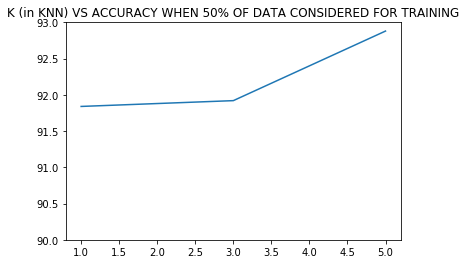

In [31]:
## K VS ACCURACY FOR 50:50
k=[1,3,5]
acc = [91.84,91.92,92.88]
plt.plot(k,acc)
plt.ylim(90,93)
plt.title("K (in KNN) VS ACCURACY WHEN 50% OF DATA CONSIDERED FOR TRAINING")
plt.show()

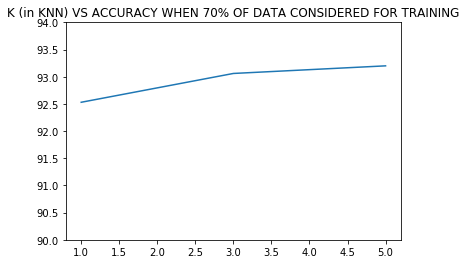

In [32]:
## K VS ACCURACY 70:30
k=[1,3,5]
acc = [92.53,93.06,93.2]
plt.plot(k,acc)
plt.ylim(90,94)
plt.title("K (in KNN) VS ACCURACY WHEN 70% OF DATA CONSIDERED FOR TRAINING")
plt.show()

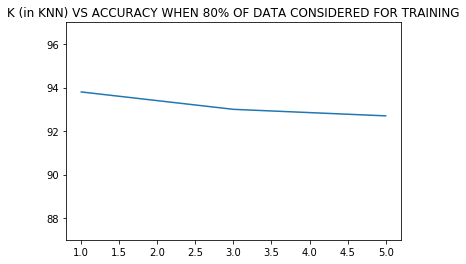

In [38]:
## K VS ACCURACY 80:20
k=[1,3,5]
acc = [93.8,93.0,92.7]
plt.plot(k,acc)
plt.ylim(87,97)
plt.title("K (in KNN) VS ACCURACY WHEN 80% OF DATA CONSIDERED FOR TRAINING")
plt.show()